In [16]:
import tdms
import imp
imp.reload(tdms)
import plot
import functions
imp.reload(functions)
import numpy as np
import scipy
import matplotlib
import filter
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Open file & plot traces

In [4]:
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/D2-vc-060717-vc2-1.tdms")
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-6.8.1701-9VCLAMPNACURRENT.tdms")
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-6.8.1702-1.tdms")
data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-CELL62_JM_gly-2-563399762.tdms")

In [5]:
data.keys()

['dt', 'yunits', u'AI0', u'AO0']

In [6]:
holding = -40
starttime = 20000

<IPython.core.display.Javascript object>


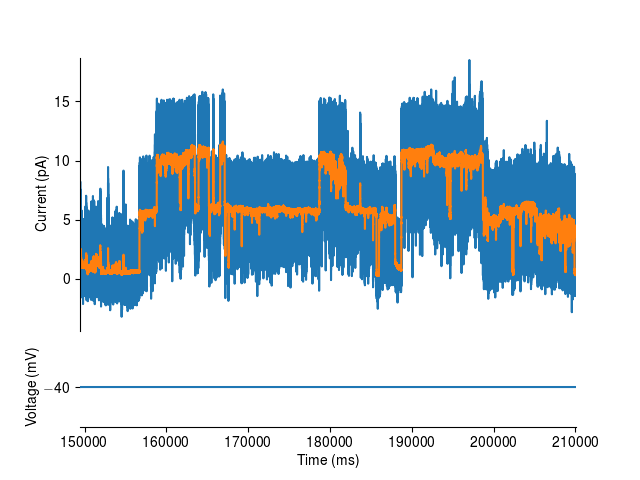

<IPython.core.display.Javascript object>


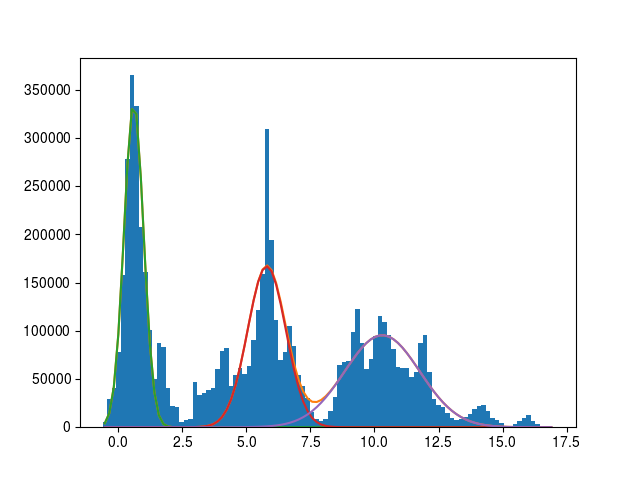

In [30]:
sweep = np.concatenate([sw for sw in data['AI0']])
sweep_filtered = filter.bandpass(sweep, data['dt'], 0.0000001, 0.02)
command = np.concatenate([co for co in data['AO0']])[:sweep.shape[0]]

fig, axi, axv = plot.plot_traces(mode='vclamp')

times = np.arange(sweep.shape[0])*data['dt']
axi.plot(times, sweep)
axi.plot(times, sweep_filtered)
axv.plot(times, holding + command)

fig = plt.figure()
res = plt.hist(sweep_filtered[int(starttime/data['dt']):], bins=100)

binvalues = res[0]
binedges = res[1]
bincentres = (res[1][:-1] + res[1][1:])/2.0

# initialization parameters for Gaussian fit
# second three are centres (1 just because)
# third three are the amplitudes (one third of the total number of data points for each gaussian)
params = [0.0, 5.0, 10.0, 1, 1, 1, sweep.shape[0]/3, sweep.shape[0]/3, sweep.shape[0]/3]

# Fit sum of three gaussians to histogram
fitted_params,_ = scipy.optimize.curve_fit(functions.tri_norm, bincentres, binvalues, p0=params)

plt.plot(bincentres, functions.tri_norm(bincentres, *fitted_params))
plt.plot(bincentres, functions.single_norm(bincentres, *fitted_params[::3]))
plt.plot(bincentres, functions.single_norm(bincentres, *fitted_params[1::3]))
plt.plot(bincentres, functions.single_norm(bincentres, *fitted_params[2::3]))

plt.show()

In [31]:
T = np.sum(binvalues)
t_openings1 = np.sum(binvalues[(bincentres>2.5) & (bincentres<7.5)])
t_openings2 = np.sum(binvalues[(bincentres>7.5)]) * 2

P_open = (t_openings1 + t_openings2)/(2.0*T)

print("P_open according to histogram sums:", P_open)

('P_open according to histogram sums:', 0.4980253689668927)


In [32]:
# Sum of all values of the sum of 3 gaussians (equivalent to T)
sum_allgaussians = np.sum(functions.tri_norm(bincentres, *fitted_params))

# Sum of the second gaussian (equivalent to t_openings1)
sum_secondgaussian = np.sum(functions.single_norm(bincentres, *fitted_params[1::3]))

# Sum of the third gaussian (equivalent to t_openings2)
sum_thirdgaussian = np.sum(functions.single_norm(bincentres, *fitted_params[2::3])) * 2

P_open = (sum_secondgaussian + sum_thirdgaussian)/(2.0*sum_allgaussians)

print("P_open according to Gaussian fit:", P_open)

('P_open according to Gaussian fit:', 0.51496281326612148)


In [33]:
fitted_params

array([  6.13032763e-01,   5.79933662e+00,   1.03020899e+01,
         3.80633841e-01,   7.41866368e-01,   1.46384277e+00,
         3.20937829e+05,   3.10417937e+05,   3.50102944e+05])

In [35]:
print("Current at peaks: {0}".format(fitted_params[:3]))

Current at peaks: [  0.61303276   5.79933662  10.30208988]
